## 0. SPECTRAL 알고리즘 ##

 - 시계열 데이터에 내재되어 있는 주기성을 찾아내는 분석 기법
 - 시계열 데이터를 일종의 주파수(FREQUENCY)로 이해하여 분석함
 - 푸리에 변환, 모수적 변환, 고유값 변환 등을 통하여 아래 이미지와 같이 주파수의 형태로 분석하는 것
 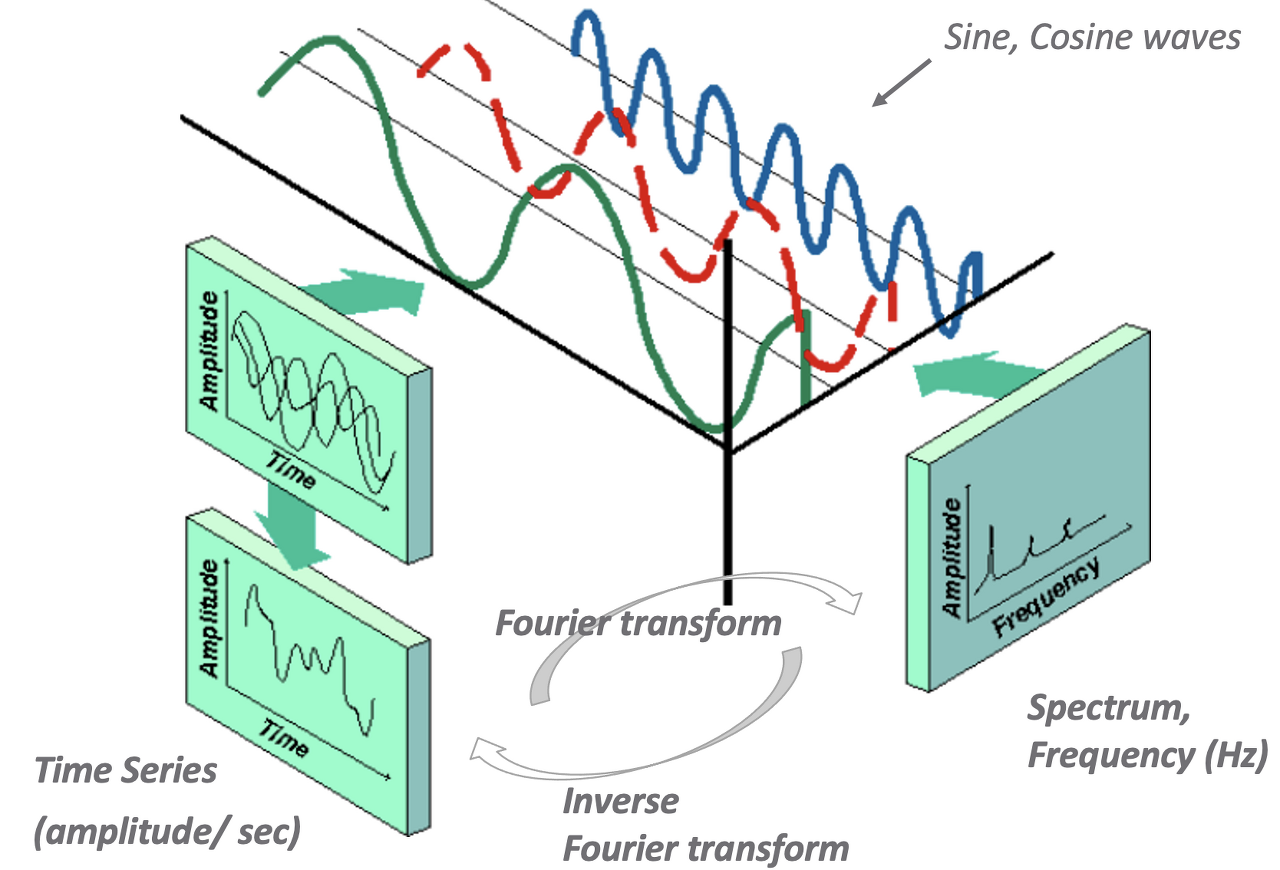
 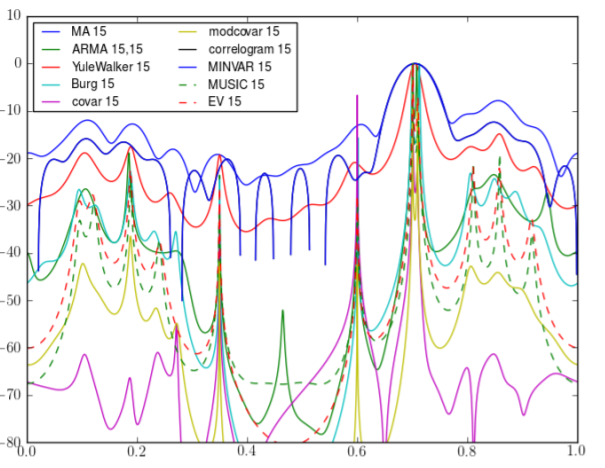

## 1. import libraries ##

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import os
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMAResults 
from spectrum import Periodogram, data_cosine

ModuleNotFoundError: No module named 'spectrum'

In [3]:
pip install spectrum

  Using cached spectrum-0.8.0.tar.gz (228 kB)
  Running setup.py clean for spectrum
Failed to build spectrum
    Running setup.py install for spectrum: started
    Running setup.py install for spectrum: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  ERROR: Command errored out with exit status 1:
   command: 'C:\anaconda3\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\Public\\Documents\\ESTsoft\\CreatorTemp\\pip-install-us39m0d5\\spectrum_f2ca709a115f4ea29743f23e81fc88ae\\setup.py'"'"'; __file__='"'"'C:\\Users\\Public\\Documents\\ESTsoft\\CreatorTemp\\pip-install-us39m0d5\\spectrum_f2ca709a115f4ea29743f23e81fc88ae\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\Public\Documents\ESTsoft\CreatorTemp\pip-wheel-hl19uxda'
       cwd: C:\Users\Public\Documents\ESTsoft\CreatorTemp\pip-install-us39m0d5\spectrum_f2ca709a115f4ea29743f23e81fc88ae\
  Complete output (45 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-3.8
  creating build\lib.win-amd64-3.8\cpp
  copying src\cpp\__init__.py -> 

## 2. import data ##

In [4]:
weather_station_location = pd.read_csv("./Weather Station Locations.csv")
weather = pd.read_csv("./Summary of Weather.csv")

In [5]:
weather_station_location = weather_station_location.loc[:,["WBAN","NAME", "STATE/COUNTRY ID", "Latitude",
                                                           "Longitude"]]
weather = weather.loc[:,["STA","Date","MeanTemp"]]
weather_station_id = weather_station_location[weather_station_location.NAME == "TELERGMA"].WBAN
weather_bin = weather[weather.STA == int(weather_station_id)]
weather_bin["Date"] = pd.to_datetime(weather_bin["Date"])
#weather_bin = weather_bin[weather_bin['Date'] < '1944-04-31']

## 3. view data ##

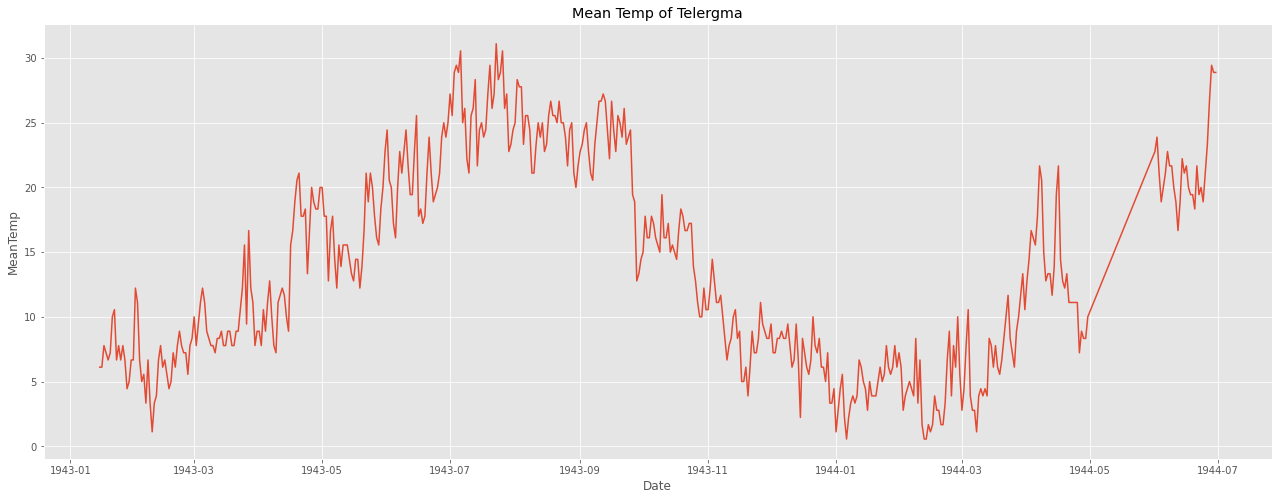

In [6]:
plt.figure(figsize=(22,8))
plt.plot(weather_bin.Date, weather_bin.MeanTemp)
plt.title("Mean Temp of Telergma")
plt.xlabel("Date")
plt.ylabel("MeanTemp")
plt.show()

In [7]:
weather_bin = weather_bin.set_index('Date')
weather_bin = weather_bin.loc['1900-6-1':'1944-4-30']
weather_bin

,STA,MeanTemp
Date,,
1943-01-15,33044,6.111111
1943-01-16,33044,6.111111
1943-01-17,33044,7.777778
1943-01-18,33044,7.222222
1943-01-19,33044,6.666667
...,...,...
1944-04-26,33044,7.222222
1944-04-27,33044,8.888889
1944-04-28,33044,8.333333


<Figure size 432x288 with 0 Axes>

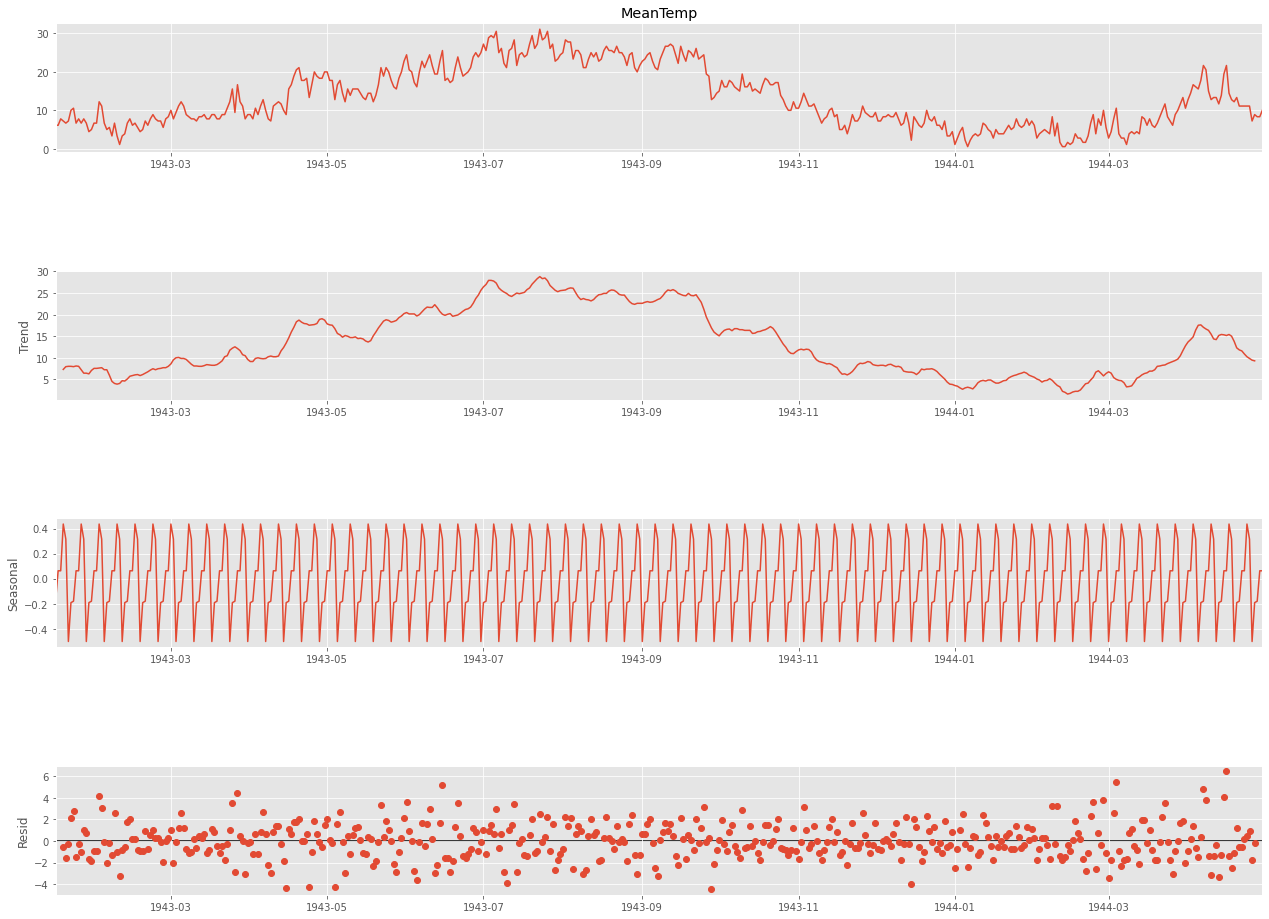

In [10]:
result = seasonal_decompose(weather_bin['MeanTemp'], model = 'additive', freq = 7) #freq 값 설정

fig = plt.figure()
fig = result.plot()
fig.set_size_inches(20,15)

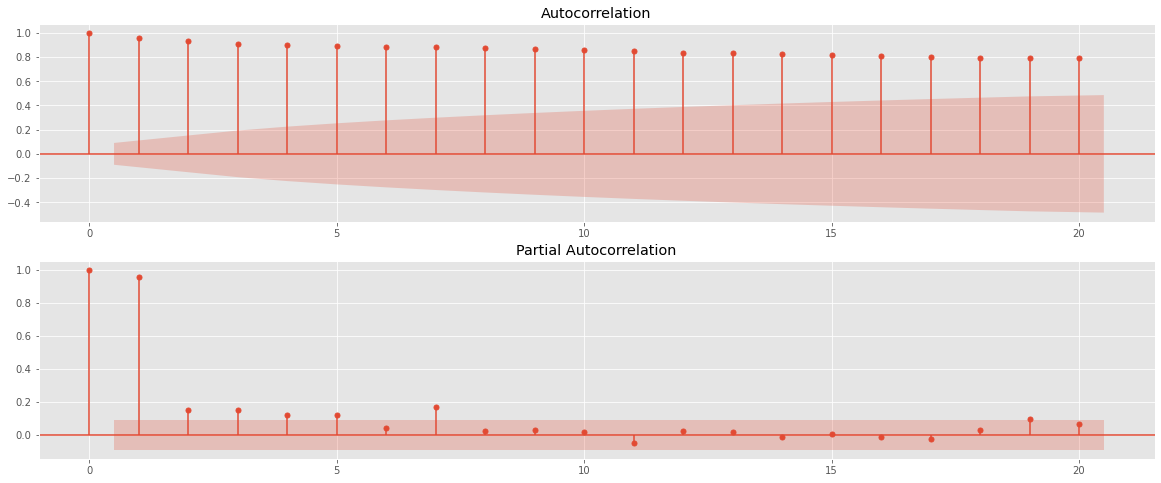

In [14]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_acf(weather_bin['MeanTemp'], lags=20, ax = ax1)
fig = sm.graphics.tsa.plot_pacf(weather_bin['MeanTemp'], lags=20, ax = ax2)

In [12]:
result = adfuller(weather_bin['MeanTemp'])
print('ADF Stat : %f'  % result[0])
print('P-value : %f'  % result[1])
print('Critical Values :')
for key,value in result[4].items() :
    print('\t%s : %.3f' % (key, value))
## As P-value is bigger than .05, cannot reject H0, which means data does not satisfies stationarity

ADF Stat : -1.492383
P-value : 0.537276
Critical Values :
	1% : -3.444
	5% : -2.868
	10% : -2.570


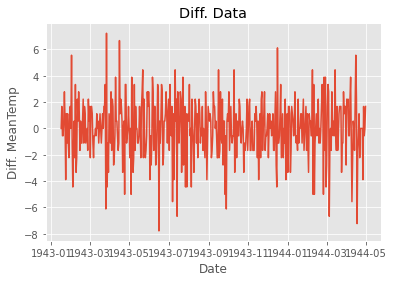

In [15]:
# 1차 차분 #
ts = weather_bin['MeanTemp']
ts_diff = ts - ts.shift()
plt.plot(ts_diff)
plt.title("Diff. Data")
plt.xlabel("Date")
plt.ylabel("Diff. MeanTemp")
plt.show()

In [16]:
result = adfuller(ts_diff[1:])
print('ADF Stat : %f'  % result[0])
print('P-value : %f'  % result[1])
print('Critical Values :')
for key,value in result[4].items() :
    print('\t%s : %.3f' % (key, value))
    
# 정상성 만족 : ARIMA(p,d,q) 에서 d 는 1

ADF Stat : -12.681594
P-value : 0.000000
Critical Values :
	1% : -3.444
	5% : -2.868
	10% : -2.570


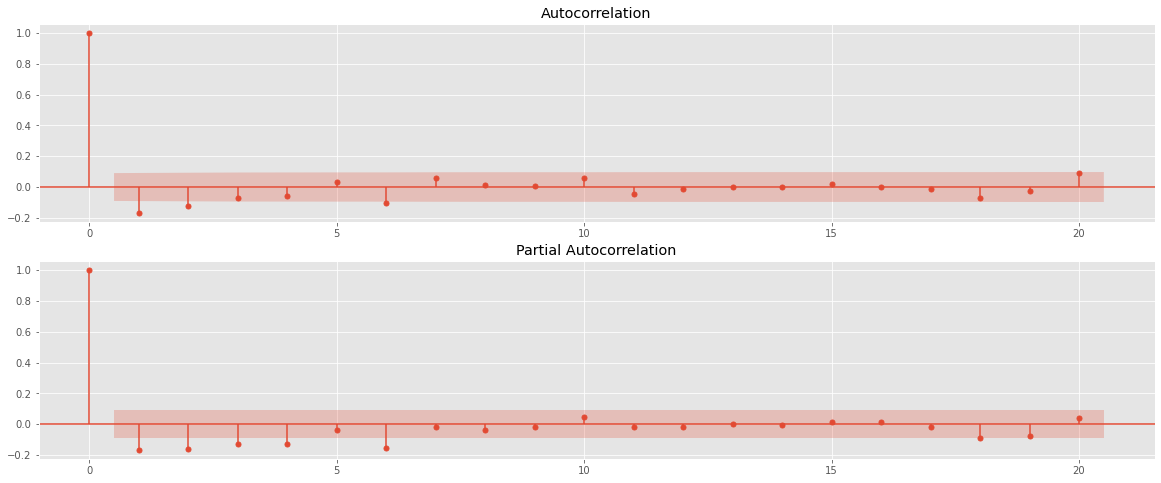

In [17]:
## p,q 정하기 ##
fig = plt.figure(figsize = (20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_diff[1:], lags = 20, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_diff[1:], lags = 20, ax = ax2)
# q = 2,1 p = 4,3,2,1

In [19]:
# Build ARIMA Model #
# model1 = ARIMA(ts, order = (4,1,2))
# model1_fit = model1.fit(disp = 0) # ar coefficient에러 -> 원래 (4,1,2)였는데 ar 4,5 모두 안됨
# print(model1_fit.summary())

model1 = ARIMA(ts, order = (6,1,2))
model1_fit = model1.fit(disp = 0) # ar coefficient에러 -> 원래 (4,1,2)였는데 (8,1,2) 로 늘림
print(model1_fit.summary()) #AIC : 2051.33

model2 = ARIMA(ts, order = (6,1,1))
model2_fit = model2.fit(disp = 0) # ar coefficient에러 -> 원래 (4,1,2)였는데 (8,1,2) 로 늘림
print(model2_fit.summary()) # AIC : 2049.62

model3 = ARIMA(ts, order = (6,1,0))
model3_fit = model3.fit(disp = 1, trend='nc', full_output=True) # ar coefficient에러 -> 원래 (4,1,2)였는데 (8,1,2) 로 늘림
print(model3_fit.summary()) # AIC : 2047.62

## PACF 가 불안한 점, 계수의 P-VALUE가 낮은점 --> 차분 한번 더 
## -> 2차 차분한 그래프가 오히려 안 좋아서 1차 차분만 함
## -> model3 를 최종 후보로 선정 & 상수의 p값이 높아 nc로 변경


C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                             ARIMA Model Results                              
Dep. Variable:             D.MeanTemp   No. Observations:                  471
Model:                 ARIMA(6, 1, 2)   Log Likelihood               -1015.665
Method:                       css-mle   S.D. of innovations              2.090
Date:                Fri, 29 Oct 2021   AIC                           2051.330
Time:                        16:42:14   BIC                           2092.878
Sample:                    01-16-1943   HQIC                          2067.675
                         - 04-30-1944                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0056      0.045      0.126      0.900      -0.082       0.093
ar.L1.D.MeanTemp    -0.1429      0.293     -0.487      0.626      -0.718       0.432
ar.L2.D.MeanTemp    -0.0744 

C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                             ARIMA Model Results                              
Dep. Variable:             D.MeanTemp   No. Observations:                  471
Model:                 ARIMA(6, 1, 1)   Log Likelihood               -1015.810
Method:                       css-mle   S.D. of innovations              2.091
Date:                Fri, 29 Oct 2021   AIC                           2049.620
Time:                        16:42:15   BIC                           2087.014
Sample:                    01-16-1943   HQIC                          2064.331
                         - 04-30-1944                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0056      0.046      0.122      0.903      -0.084       0.095
ar.L1.D.MeanTemp    -0.0564      0.348     -0.162      0.872      -0.739       0.627
ar.L2.D.MeanTemp    -0.1884 

C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                             ARIMA Model Results                              
Dep. Variable:             D.MeanTemp   No. Observations:                  471
Model:                 ARIMA(6, 1, 0)   Log Likelihood               -1015.939
Method:                       css-mle   S.D. of innovations              2.091
Date:                Fri, 29 Oct 2021   AIC                           2045.879
Time:                        16:42:16   BIC                           2074.963
Sample:                    01-16-1943   HQIC                          2057.320
                         - 04-30-1944                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
ar.L1.D.MeanTemp    -0.2384      0.046     -5.237      0.000      -0.328      -0.149
ar.L2.D.MeanTemp    -0.2308      0.047     -4.941      0.000      -0.322      -0.139
ar.L3.D.MeanTemp    -0.1837 

(array([9.71554734]), array([2.09109418]), array([[ 5.61707805, 13.81401663]]))


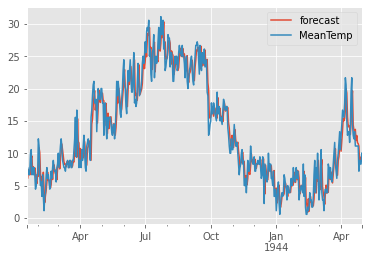

In [23]:
## 예측된 값 그래프로 보기 ##
model3_fit.plot_predict()
fore = model3_fit.forecast(steps=1)
print(fore)
## 9.71도로 예측함
## Q2. array 의 뜻
## A. 1스텝 후의 예측값, std, Lower & Upper bound (95% c.i)

In [ ]:
## 2차 차분 ##
ts_diff_2 = ts.diff().diff()
plt.plot(ts_diff_2)
plt.title("Diff2. Data")
plt.xlabel("Date")
plt.ylabel("Diff2. MeanTemp")
plt.show()

In [ ]:
result = adfuller(ts_diff_2[2:])
print('ADF Stat : %f'  % result[0])
print('P-value : %f'  % result[1])
print('Critical Values :')
for key,value in result[4].items() :
    print('\t%s : %.3f' % (key, value))
    
# d는 2가 됨

In [ ]:
## p,q 정하기 ##
fig = plt.figure(figsize = (20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_diff_2[2:], lags = 20, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_diff_2[2:], lags = 20, ax = ax2)

## 2차 차분한 결과 PACF가 더 큰폭으로 뜀 -> 2차 차분 하지 않음.

In [31]:
weather_bin

,STA,Date,MeanTemp
82557,33044,1943-01-15,6.111111
82558,33044,1943-01-16,6.111111
82559,33044,1943-01-17,7.777778
82560,33044,1943-01-18,7.222222
82561,33044,1943-01-19,6.666667
...,...,...,...
83054,33044,1944-06-26,23.333333
83055,33044,1944-06-27,26.666667
83056,33044,1944-06-28,29.444444
83057,33044,1944-06-29,28.888889
